# Plan
1. read data, split to labels and data, reshape data for Convulotional networks
2. explore data, view all categories
3. make dense model (model_1 in preivous notebook)
4. convulotional model (model_2 current notebook)
5. pretrained network ResNet50
6. Transfer learning with ResNet50 
7. Use GPU (Plaidml)for fiting Transfer learning with ResNet50

In [1]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
from keras.utils import to_categorical
from keras.models import Sequential

from keras.callbacks import EarlyStopping
from keras import preprocessing 
from keras import backend as K
from skimage.transform import resize
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from keras.applications.resnet50 import ResNet50, decode_predictions,preprocess_input
from keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from keras import models, layers


# Read Data

In [3]:
from keras.datasets import fashion_mnist
(xtrain,ytrain),(xtest,ytest) =fashion_mnist.load_data()
#reshape
xtrain= xtrain.reshape((60000, 28, 28,1))
xtest= xtest.reshape((10000, 28, 28,1))


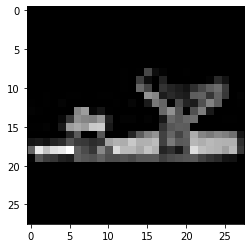

In [5]:
plt.imshow(xtrain[59999],cmap='gray')

In [4]:
# convert to RGB because ResNet input is RGB function
def img_set_to_rgb(data):
   img=[]
   #img=np.empty(data.shape)
   for i in range (len(data)):
       img_gray=data[i,:,:,:]
       img_rgb =cv2.cvtColor(img_gray,cv2.COLOR_GRAY2RGB)
       img.append(img_rgb) 
       
   img = np.asarray(img)
   return img   

In [5]:
# convert to RGB because ResNet input
xtest=img_set_to_rgb(xtest)
xtrain=img_set_to_rgb(xtrain)
xtrain.shape,xtest.shape


((60000, 28, 28, 3), (10000, 28, 28, 3))

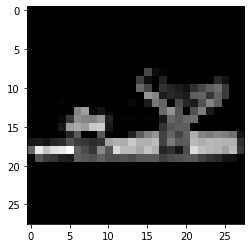

In [8]:
plt.imshow(xtrain[59999],cmap='gray')

<h5>Define labels </h5>


In [6]:
# dictionary of labels 
true_labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

# 4th model: Transfer learning with ResNet50
<h3> prepproceesing required </h3>

In [7]:
# convert to RGB because ResNet input is RGB function
def scale_img(data,width, height):
   img=[]
   dim = (width, height)
   for i in range (len(data)):
       img_var=data[i,:,:,:]
       img_resized =cv2.resize(img_var, dim, interpolation = cv2.INTER_AREA)
       img.append(img_resized) 
       
   img = np.asarray(img)
   return img   

In [8]:
#rescale image to the input data shape
X_train_image=scale_img(xtrain,224,224)
X_test_image=scale_img(xtest,224,224)

In [9]:
# preprocessing
X_train_image = preprocess_input(X_train_image)
X_test_image = preprocess_input(X_test_image)

In [13]:
X_train_image.shape, X_train_image.dtype

((60000, 224, 224, 3), dtype('float32'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


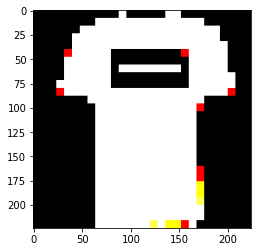

In [14]:
plt.imshow(X_train_image[1])  # come back to it

# Another way

In [38]:
classes=list(true_labels.values())

In [39]:
# imgae data generator and th efunctions to be applied to it
data_gen = preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [50]:
X_train_image.shape

(60000, 224, 224, 3)

In [ ]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow(X_train_image,y_train, subset='training', batch_size=30)

In [ ]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

# Transfer learning model

In [10]:
y_test = to_categorical(ytest)
y_train = to_categorical(ytrain)

In [11]:
model_4 = keras.Sequential()
model_4.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model_4.add(Dense(10, activation = 'softmax'))

model_4.layers[0].trainable = False
model_4.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_455.0"


A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a268eb855778b3df3c7506639542a6af so we will re-download the data.
94658560/94653016 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


# Compile and fit

In [14]:


model_4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])              

# observe the validation loss and stop when it does not improve after 3 iterations
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)
model_2_training = model_4.fit(X_train_image, y_train, epochs=40, batch_size = 50, validation_split=0.3, callbacks=[early_stopping_monitor], verbose=1)


Train on 42000 samples, validate on 18000 samples
Epoch 1/40
42000/42000 [==============================] - 5538s 132ms/step - loss: 0.5026 - acc: 0.8246 - val_loss: 2.6757 - val_acc: 0.3251
Epoch 2/40
42000/42000 [==============================] - 5529s 132ms/step - loss: 0.3419 - acc: 0.8773 - val_loss: 3.4034 - val_acc: 0.2577
Epoch 3/40
42000/42000 [==============================] - 5175s 123ms/step - loss: 0.3101 - acc: 0.8879 - val_loss: 2.9284 - val_acc: 0.2603
Epoch 4/40
42000/42000 [==============================] - 4890s 116ms/step - loss: 0.2886 - acc: 0.8943 - val_loss: 3.5111 - val_acc: 0.2247


In [15]:
model_4.save("transfer-learning-GPU.h5")

OSError: Unable to create file (unable to open file: name = 'models/transfer-learning-GPU.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [28]:
# predications
pred = model_3.predict(X_test_image)

In [29]:
type(pred)

numpy.ndarray

In [32]:
pred.shape

(10000, 1000)

In [34]:
labels = decode_predictions(pred, top=5)

In [53]:
labels[1]

[('n02815834', 'beaker', 0.11084313),
 ('n02948072', 'candle', 0.107683435),
 ('n03630383', 'lab_coat', 0.0824849),
 ('n03998194', 'prayer_rug', 0.07748717),
 ('n03197337', 'digital_watch', 0.06745113)]

In [49]:
ytest[1]

2

In [74]:
true_labels[ytest[1]]

'Pullover'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

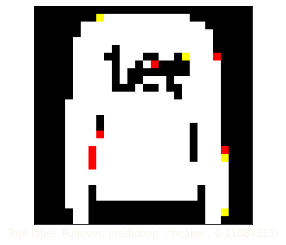

In [76]:

test=plt.imshow(X_test_image[1],cmap='gray')
plt.xlabel('True label: ' +str(true_labels[ytest[1]])+ '; prediction :'+ str(labels[1][0][1:3]), color='#F9F6EE')
ax = plt.gca()
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])


In [77]:
#save the predciations
np.savetxt("model_3.csv", pred, delimiter=",")